# PyWake P2X Example

A hybrid power plant with wind, solar, storage and power-to-gas is evaluated 
using a PyWake based wind farm model, and selected outputs are plotted.

In [0]:
# Install hydesign if needed
import importlib
if not importlib.util.find_spec("hydesign"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git

In [ ]:
# Install pywake if needed
if not importlib.util.find_spec("py_wake"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git   

In [1]:
import numpy as np
import pandas as pd
from hydesign.assembly.hpp_pywake_p2x import hpp_model
from hydesign.examples import examples_filepath
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.turbulence_models.stf import STF2017TurbulenceModel
from py_wake import NOJ
from py_wake.deflection_models import JimenezWakeDeflection
from py_wake.examples.data.dtu10mw_surrogate import DTU10MW_1WT_Surrogate
from py_wake.superposition_models import LinearSum
from topfarm.utils import regular_generic_layout
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

## Setting up the model

In [2]:
name = 'Denmark_good_wind'
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0, sep=';')
ex_site = examples_sites.loc[examples_sites.name == name]

longitude = ex_site['longitude'].values[0]
latitude = ex_site['latitude'].values[0]
altitude = ex_site['altitude'].values[0]
sim_pars_fn = examples_filepath + ex_site['sim_pars_fn'].values[0]
input_ts_fn = examples_filepath + ex_site['input_ts_fn'].values[0]

intervals_per_hour = 1
n_wt = 40
n_loads = 4
wt = DTU10MW_1WT_Surrogate()
d = wt.diameter()
site = Hornsrev1Site()
sx = 4 * d
sy = 5 * d
x, y = regular_generic_layout(n_wt, sx, sy, stagger=0, rotation=0)
N_ws = 365 * 24 * intervals_per_hour
time_stamp = np.arange(N_ws) / 6 / 24
farm = NOJ(site, wt, turbulenceModel=STF2017TurbulenceModel(),
    deflectionModel=JimenezWakeDeflection(), superpositionModel=LinearSum())
yaw = 30 * np.sin(np.arange(N_ws) / 100)
tilt = np.zeros(N_ws)

hpp = hpp_model(latitude=latitude,
                longitude=longitude,
                altitude=altitude,
                sim_pars_fn=sim_pars_fn,
                input_ts_fn=input_ts_fn,
                intervals_per_hour=intervals_per_hour,
                farm=farm,
                x=x,
                y=y,
                tilt=tilt,
                time_stamp=time_stamp,
                n_loads=n_loads,
                H2_demand_fn=6000,
               Nwt=n_wt)

c:\Users\mikf\Anaconda3\envs\hydesign2\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\mikf\Anaconda3\envs\hydesign2\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
C:\Sandbox\Repo\TOPFARM\PyWake\py_wake\deficit_models\noj.py:84: UserWarning: The NOJ model is not representative of the setup used in the literature. For this, use py_wake.literature.noj.Jensen_1983 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.noj.Jensen_1983')



Fixed parameters on the site
-------------------------------
longitude = 8.594398
latitude = 56.227322
altitude = 85.0


## Evaluate the design

In [ ]:
p_rated = 10.0
points = np.asarray([x, y]).T
hull = ConvexHull(points)
area = hull.volume * 1e-6
wind_MW_per_km2 = 3
clearance = wt.hub_height() - d / 2
sp = 360

inputs = dict(clearance=clearance, sp=sp, p_rated=p_rated, Nwt=n_wt, wind_MW_per_km2=wind_MW_per_km2,
              solar_MW=200, surface_tilt=45, surface_azimuth=180, DC_AC_ratio=1.5,
              b_P=40, b_E_h=4, cost_of_battery_P_fluct_in_peak_price_ratio=5,
              ptg_MW=800, HSS_kg=5000,
              yaw=yaw)

outs = hpp.evaluate(**inputs)
hpp.print_design()

C:\Sandbox\Repo\TOPFARM\hydesign\hydesign\ems\ems_P2X.py:1099: RuntimeWarning: invalid value encountered in divide
  f_ptg = np.nan_to_num(P_ptg_t / (wind_t + solar_t + b_t))
C:\Sandbox\Repo\TOPFARM\hydesign\hydesign\ems\ems_P2X.py:1116: RuntimeWarning: divide by zero encountered in divide
  m_H2_offtake_t_deg = np.nan_to_num(m_H2_offtake_t / m_H2_t) * m_H2_t_deg
C:\Sandbox\Repo\TOPFARM\hydesign\hydesign\ems\ems_P2X.py:1116: RuntimeWarning: invalid value encountered in divide
  m_H2_offtake_t_deg = np.nan_to_num(m_H2_offtake_t / m_H2_t) * m_H2_t_deg



Design:
---------------
clearance [m]: 29.850
sp [W/m2]: 360.000
p_rated [MW]: 10.000
Nwt: 40.000
wind_MW_per_km2 [MW/km2]: 3.000
solar_MW [MW]: 200.000
surface_tilt [deg]: 45.000
surface_azimuth [deg]: 180.000
DC_AC_ratio: 1.500
b_P [MW]: 40.000
b_E_h [h]: 4.000
cost_of_battery_P_fluct_in_peak_price_ratio: 5.000
ptg_MW [MW]: 800.000
HSS_kg [kg]: 5000.000
Yaw offset [deg]: mean, std, min, max 0.02312121.253333-29.99999430.000000


NPV_over_CAPEX: -0.012
NPV [MEuro]: -14.123
IRR: 0.000
LCOE [Euro/MWh]: 42.212
Revenues [MEuro]: 2046.103
CAPEX [MEuro]: 1159.921
OPEX [MEuro]: 22.807
Wind CAPEX [MEuro]: 344.319
Wind OPEX [MEuro]: 7.566
PV CAPEX [MEuro]: 67.000
PV OPEX [MEuro]: 1.350
Batt CAPEX [MEuro]: 16.119
Batt OPEX [MEuro]: 0.000
Shared CAPEX [MEuro]: 90.982
Shared OPEX [MEuro]: 0.000
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 43.474
GUF: 0.017
grid [MW]: 300.000
wind [MW]: 400.000
solar [MW]: 200.000
Battery Energy [MWh]: 160.000
Battery Power [MW]: 40.000
Total curtailment [GWh]: 0.0

## Plotting example output

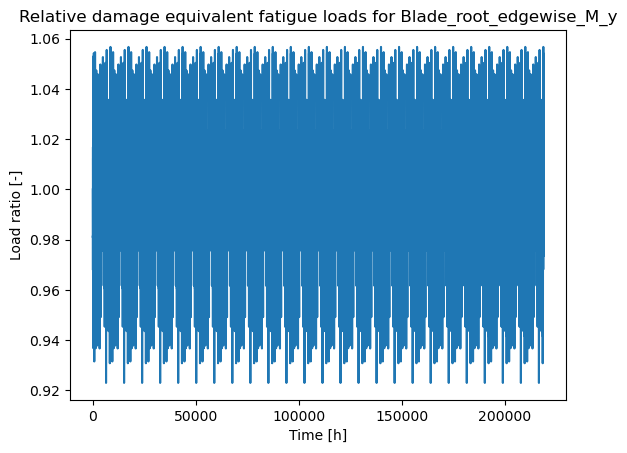

In [4]:
sensors = wt.loadFunction.output_keys
sensor_no = 0
turb = 0
plt.figure()
plt.plot(hpp.prob['loads_rel_ext'][sensor_no, turb, :])
plt.xlabel('Time [h]')
plt.ylabel('Load ratio [-]')
plt.title(f'Relative damage equivalent fatigue loads for {sensors[sensor_no]}')
plt.show()